<a href="https://colab.research.google.com/github/ChrisHarvey21/EnvDatSci22/blob/master/CodeSprints/multicollinearity_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multicollinearity and Regression Analysis
In this tutorial, we will be using a spatial dataset of county-level election and demographic statistics for the United States. This time, we'll explore different methods to diagnose and account for multicollinearity in our data. Specifically, we'll calculate variance inflation factor (VIF), and compare parameter estimates and model fit in a multivariate regression predicting 2016 county voting preferences using an OLS model, a ridge regression, a lasso regression, and an elastic net regression.

Objectives:
* ***Calculate a variance inflation factor to diagnose multicollinearity.***
* ***Use geographicall weighted regression to identify if the multicollinearity is scale dependent.***
* ***Interpret model summary statistics.***
* ***Describe how multicollinearity impacts stability in parameter esimates.***
* ***Explain the variance/bias tradeoff and describe how to use it to improve models***
* ***Draw a conclusion based on contrasting models.***

Review: 
* [Dormann, C. et al. (2013). Collinearity: a review of methods to deal with it and a simulation study evaluating their performance. Ecography, 36(1), 27-46.](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1600-0587.2012.07348.x)


In [1]:
%%capture
!pip install geopandas
!pip install libpysal

In [2]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from numpy import mean
from numpy import std
from numpy import absolute
from libpysal.weights.contiguity import Queen
import libpysal
from statsmodels.api import OLS
sns.set_style('white')

First, we're going to load the 'Elections' dataset from the libpysal library, which is a very easy to use API that accesses the Geodata Center at the University of Chicago.

* More on spatial data science resources from UC: https://spatial.uchicago.edu/
* A list of datasets available through lipysal: https://geodacenter.github.io/data-and-lab//

In [3]:
from libpysal.examples import load_example
elections = load_example('Elections')
#note the folder where your data now lives:


Example not available: Elections
Example not downloaded: Chicago parcels
Example not downloaded: Chile Migration
Example not downloaded: Spirals


In [4]:
#First, let's see what files are available in the 'Elections' data example
elections.get_file_list()

['/root/.local/share/pysal/Elections/__MACOSX/election/._election.shp',
 '/root/.local/share/pysal/Elections/election/election.dbf',
 '/root/.local/share/pysal/Elections/election/election.shx',
 '/root/.local/share/pysal/Elections/election/election.shp',
 '/root/.local/share/pysal/Elections/election/election.prj']

When you are out in the world doing research, you often will not find a ready-made function to download your data. That's okay! You know how to get this dataset without using pysal! Do a quick internal review of online data formats and automatic data downloads.

### TASK 1: Use urllib functions to download this file directly from the internet to a folder. Extract the zipped file you've downloaded into a subfolder called elections.

In [5]:
# Task 1 code here:
#import required function:
import urllib.request

#define online filepath (aka url):
url = 'https://geodacenter.github.io/data-and-lab//data/election.zip'

#define local filepath:
local = "elections.zip"

#download elections data:
urllib.request.urlretrieve(url, local)

#unzip file: see if google can help you figure this one out!
!unzip elections.zip

Archive:  elections.zip
   creating: election/
  inflating: election/election.prj   
  inflating: election/election.shx   
  inflating: election/election.shp   
   creating: __MACOSX/
   creating: __MACOSX/election/
  inflating: __MACOSX/election/._election.shp  
  inflating: election/election.dbf   


In [15]:
!cd .
!ls


election  elections.zip  __MACOSX  sample_data


In [22]:
print(elections
      )

### TASK 2: Use geopandas to read in this shapefile. Call your geopandas.DataFrame "votes"

In [25]:
# TASK 2: Use geopandas to read in this shapefile. Call your geopandas.DataFrame "votes"
votes = gpd.read_file('election/election.shp')


### EXTRA CREDIT TASK (+2pts): use os to delete the elections data downloaded by pysal that you are no longer using.

In [ ]:
# Extra credit task:


In [ ]:
#Let's view the shapefile to get a general idea of the geometry we're looking at:
%matplotlib inline
votes.plot()

In [ ]:
#View the first few line]s of the dataset
votes.head()

In [ ]:
#Since there are too many columns for us to view on a signle page using "head", we can just print out the column names so we have them all listed for reference
for col in votes.columns: 
    print(col) 

#### You can use pandas summary statistics to get an idea of how county-level data varies across the United States. 
### TASK 3: For example, how did the county mean percent Democratic vote change between 2012 (pct_dem_12) and 2016 (pct_dem_16)?

Look here for more info on pandas summary statistics:https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/pandas-dataframes/run-calculations-summary-statistics-pandas-dataframes/

In [31]:
#Task 3
votes[["pct_dem_12", "pct_dem_16"]].mean()

pct_dem_12    0.384502
pct_dem_16    0.316667
dtype: float64

We can also plot histograms of the data. Below, smoothed histograms from the seaborn package (imported as sns) let us get an idea of the distribution of percent democratic votes in 2012 (left) and 2016 (right).

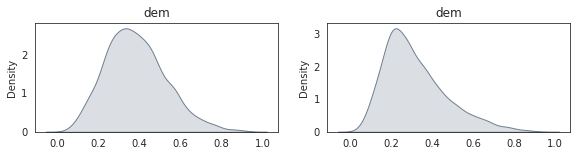

In [32]:
# Plot histograms:
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])
    ax[i].set_title(col.split('_')[1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


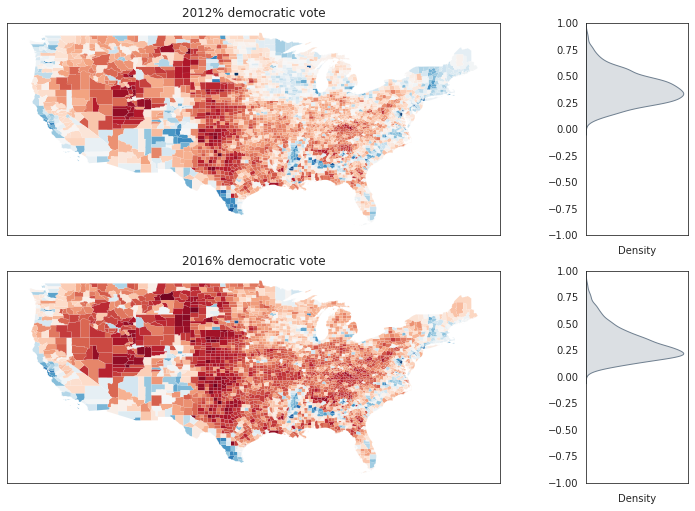

In [33]:
# Plot spatial distribution of # dem vote in 2012 and 2016 with histogram.
f,ax = plt.subplots(2,2, figsize=(1.6*6 + 1,2.4*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    votes.plot(col, linewidth=.05, cmap='RdBu', ax=ax[i,0])
    ax[i,0].set_title(['2012','2016'][i] + "% democratic vote")
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

### TASK 4: Make a new column on your geopandas dataframe called "pct_dem_change" and plot it using the syntax above. Explain the plot.

In [42]:
# Task 4: add new column pct_dem_change to votes:
votes['pct_dem_change'] = votes['pct_dem_16'] - votes['pct_dem_12']
votes

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,geometry,pct_dem_change
0,01,005,01005,2.291821e+09,5.086468e+07,Barbour County,AL,26887.0,27457.0,-2.1,...,5873.0,5539.0,5.0,1.0,0.512523,0.483376,334.0,0.029147,"POLYGON ((-85.748 31.619, -85.745 31.619, -85....",-0.045920
1,01,023,01023,2.365955e+09,1.905925e+07,Choctaw County,AL,13323.0,13858.0,-3.9,...,3785.0,4150.0,23.0,1.0,0.475204,0.521030,365.0,-0.045825,"POLYGON ((-88.473 31.894, -88.469 31.930, -88....",-0.047438
2,01,035,01035,2.201896e+09,6.643480e+06,Conecuh County,AL,12670.0,13228.0,-4.2,...,3551.0,3434.0,35.0,1.0,0.506345,0.489662,117.0,0.016683,"POLYGON ((-87.427 31.264, -87.426 31.268, -87....",-0.037294
3,01,051,01051,1.601877e+09,9.985074e+07,Elmore County,AL,80977.0,79296.0,2.1,...,8940.0,26223.0,51.0,1.0,0.252257,0.739927,17283.0,-0.487669,"POLYGON ((-86.413 32.751, -86.371 32.751, -86....",-0.023670
4,01,065,01065,1.667805e+09,3.252587e+07,Hale County,AL,15184.0,15760.0,-3.7,...,5401.0,3205.0,65.0,1.0,0.625985,0.371465,2196.0,0.254520,"POLYGON ((-87.870 32.762, -87.868 32.766, -87....",-0.030230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,45,019,45019,2.372842e+09,1.144346e+09,Charleston County,SC,381015.0,350204.0,8.8,...,81027.0,77248.0,19.0,45.0,0.503730,0.480237,3779.0,0.023493,"MULTIPOLYGON (((-79.508 33.020, -79.507 33.020...",0.002656
3104,45,077,45077,1.285536e+09,4.061259e+07,Pickens County,SC,120368.0,119226.0,1.0,...,11122.0,33385.0,77.0,45.0,0.244859,0.734996,22263.0,-0.490137,"MULTIPOLYGON (((-82.867 34.617, -82.865 34.617...",-0.033548
3105,46,123,46123,4.176234e+09,1.327278e+07,Tripp County,SD,5512.0,5644.0,-2.3,...,737.0,1905.0,123.0,46.0,0.273876,0.707915,1168.0,-0.434039,"POLYGON ((-100.231 43.500, -100.230 43.500, -1...",-0.098210
3106,47,073,47073,1.261443e+09,3.254540e+07,Hawkins County,TN,56735.0,56836.0,-0.2,...,5086.0,14376.0,73.0,47.0,0.257011,0.726464,9290.0,-0.469453,"POLYGON ((-83.289 36.379, -83.282 36.382, -83....",-0.087784


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


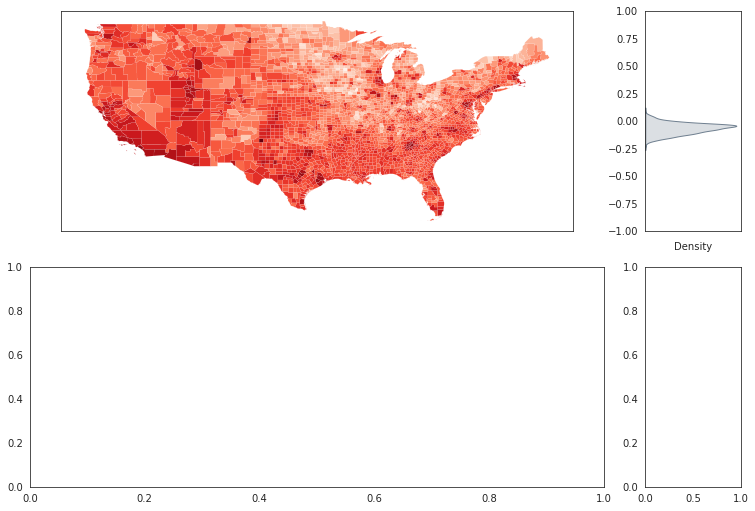

In [48]:
#Task 4: plot your pct_dem_change variable on a map:
f,ax = plt.subplots(2,2, figsize=(1.6*6 + 1,2.4*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_change']):
    votes.plot(col, linewidth=.05, cmap='Reds', ax=ax[i,0])
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

Click on this url to learn more about the variables in this dataset: https://geodacenter.github.io/data-and-lab//county_election_2012_2016-variables/
As you can see, there are a lot of data values available in this dataset. Let's say we want to learn more about what county-level factors influence percent change in democratic vote between (pct_dem_change).

Looking at the data description on the link above, you see that this is an exceptionally large dataset with many variables. During lecture, we discussed how there are two types of multicollinearity in our data:

* *Intrinsic multicollinearity:* is an artifact of how we make observations. Often our measurements serve as proxies for some latent process (for example, we can measure percent silt, percent sand, and percent clay as proxies for the latent variable of soil texture). There will be slight variability in the information content between each proxy measurement, but they will not be independent of one another.

* *Incidental collinearity:* is an artifact of how we sample complex populations. If we collect data from a subsample of the landscape where we don't see all combinations of our predictor variables (do not have good cross replication across our variables). We often induce collinearity in our data just because we are limitted in our ability to sample the environment at the scale of temporal/spatial variability of our process of interest. Incidental collinearity is a model formulation problem.(See here for more info on how to avoid it: https://people.umass.edu/sdestef/NRC%20601/StudyDesignConcepts.pdf)

### TASK 5: Looking at the data description, pick two variables that you believe will be intrinsically multicollinear. List and describe these variables. Why do you think they will be collinear? Is this an example of *intrinsic* or *incidental* collinearity?

*Click on this box to enter text*
I chose:   
* "RHI125214", #White alone, percent, 2014
* "RHI225214", #Black or African American alone, percent, 2014
These variables are intrinsically multicollinear. A decrease in one of a finite number of races implicitly signifies an increase in another race.


I chose:   
* "pct_dem_16", Votes for Democratic candiataes as percent of total votes

* "pct_gop_16", Votes for Republican candiatates as percent of total votes

These variables are intrinsically multicollinear. A decrease in either of these will implicitly signifies an increase in the amount of votes for the other.

## Multivariate regression in observational data:
Our next step is to formulate our predictive/diagnostic model. We want to create a subset of the "votes" geopandas data frame that contains ten predictor variables and our response variable (pct_pt_16) two variables you selected under TASK 1. First, create a list of the variables you'd like to select.

### TASK 6: Create a subset of votes called "my_list" containing only your selected predictor variables. Make sure you use the two variables selected under TASK 3, and eight additional variables

In [ ]:
# Task 4: create a subset of votes called "my list" with all your subset variables.
#my_list = ["pct_pt_16", <list your variables here>]      

In [ ]:
#check to make sure all your columns are there:
votes[my_list].head()

### Scatterplot matrix
We call the process of getting to know your data (ranges and distributions of the data, as well as any relationships between variables) "exploratory data analysis". Pairwise plots of your variables, called scatterplots, can provide a lot of insight into the type of relationships you have between variables. A scatterplot matrix is a pairwise comparison of all variables in your dataset.

In [ ]:
#Use seaborn.pairplot to plot a scatterplot matrix of you 10 variable subset:
sns.pairplot(votes[my_list])

### TASK 7: Do you observe any collinearity in this dataset? How would you describe the relationship between your two "incidentally collinear" variables that you selected based on looking at variable descriptions? 

*Type answer here*


### TASK 8: What is plotted on the diagonal panels of the scatterplot matrix?

*Type answer here*


## Diagnosing collinearity globally:
During class, we discussed the Variance Inflation Factor, which describes the magnitude of variance inflation that can be expected in an OLS parameter estimate for a given variable *given pairwise collinearity between that variable and another variable*. 

In [ ]:
#VIF = 1/(1-R2) of a pairwise OLS regression between two predictor variables
#We can use a built-in function "variance_inflation_factor" from statsmodel.api to calculate VIF
#Learn more about the function
?variance_inflation_factor

In [ ]:
#Calculate VIFs on our dataset
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(votes[my_list[1:11]].values, i) for i in range(votes[my_list[1:11]].shape[1])]
vif["features"] = votes[my_list[1:11]].columns


In [ ]:
vif.round()

### Collinearity is always present in observational data. When is it a problem?
Generally speaking, VIF > 10 are considered "too much" collinearity. But this value is somewhat arbitrary: the extent to which variance inflation will impact your analysis is highly context dependent. There are two primary contexts where variance inflation is problematic:

 1\. **You are using your analysis to evaluate variable importance:** If you are using parameter estimates from your model to diagnose which observations have physically important relationships with your response variable, variance inflation can make an important predictor look unimportant, and parameter estimates will be highly leveraged by small changes in the data. 

 2\. **You want to use your model to make predictions in a situation where the specific structure of collinearity between variables may have shifted:** When training a model on collinear data, the model only applies to data with that exact structure of collinearity.

### Caluculate a linear regression on the global data:
In this next step, we're going to calculate a linear regression in our data an determine whether there is a statistically significant relationship between per capita income and percent change in democratic vote.

In [ ]:
#first, forumalate the model. See weather_trend.py in "Git_101" for a refresher on how.

#extract variable that you want to use to "predict"
X = np.array(votes[my_list[1:11]].values)
#standardize data to assist in interpretation of coefficients
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

#extract variable that we want to "predict"
Y = np.array(votes['pct_dem_change'].values)
#standardize data to assist in interpretation of coefficients
Y = (Y - np.mean(X)) / np.std(Y)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()

In [ ]:
print(lm_results)

### TASK 9: Answer: which coefficients indicate a statisticall significant relationship between parameter and pct_dem_change? What is your most important predictor variable? How can you tell?

*Type answer here*


### TASK10:  Are any of these parameters subject to variance inflation? How can you tell?

*Type answer here*


Now, let's plot our residuals to see if there are any spatial patterns in them.

Remember residuals = predicted - fitted values

In [ ]:
#Add model residuals to our "votes" geopandas dataframe:
votes['lm_resid']=OLS(Y,X).fit().resid


In [ ]:
#Add model coefficients to you "vif" geopandas dataframe:
vif['OLS_coef']=OLS(Y,X).fit().params

In [ ]:
#Plot histogram of model residuals
sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')


### TASK 11: Are our residuals normally distributed with a mean of zero? What does that mean?

*Type answer here*


## Penalized regression: ridge penalty
In penalized regression, we intentionally bias the parameter estimates to stabilize them given collinearity in the dataset.

From https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
"As mentioned before, ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. Thus, ridge regression optimizes the following:

**Objective = RSS + α * (sum of square of coefficients)**

Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

* **α = 0:** The objective becomes same as simple linear regression. We’ll get the same coefficients as simple linear regression.

* **α = ∞:** The coefficients will approach zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.

* **0 < α < ∞:** The magnitude of α will decide the weightage given to different parts of objective. The coefficients will be somewhere between 0 and ones for simple linear regression."

In other words, the ridge penalty shrinks coefficients such that collinear coefficients will have more similar coefficient values. It has a "grouping" tendency.

In [ ]:
# when L2=0, Ridge equals OLS
model = Ridge(alpha=1)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
vif['Ridge_coef']=model.coef_

### Hyperparameter tuning
The L2 coefficient (called alpha above) is a free parameter (hyperparameter) in the model, meaning we can set it whatever value we feel is best.

In machine learning, we often try multiple options for these hyperparameters, and select the value with the highest model performance.

In [ ]:
# Train on a range of alphas
alpha = np.arange(0,20,0.1)
ridge_tune=pd.DataFrame(alpha, columns=["alpha"])
ridge_tune['Score']=0
i=0
for a in alpha:
  model= Ridge(alpha=a)
  oos_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  #force scores to be positive
  oos_scores = absolute(oos_scores)
  ridge_tune.Score.loc[i]=mean(oos_scores)
  i=i+1


In [ ]:
# Plot model performance as a function of alpha
plt.plot(ridge_tune.alpha, ridge_tune.Score)
plt.show()

In [ ]:
# Select the value of alpha which minimizes MAE
a2 = ridge_tune.alpha.iloc[ridge_tune['Score'].idxmin()]
a2

In [ ]:
# Train model with optimized alpha
model = Ridge(alpha=a2)
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
vif['Ridge_coef']=model.coef_

## Penalized regression: lasso penalty

From https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
> LASSO stands for Least Absolute Shrinkage and Selection Operator. 

There are 2 key words here – **absolute** and **selection**.

Lets consider the former first and worry about the latter later.
.
Lasso regression performs L1 regularization, i.e. it adds a factor to the sum of absolute value of coefficients in the optimization objective. Thus, lasso regression optimizes the following:

**Objective = RSS + α * (sum of absolute value of coefficients)**

Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. Like that of ridge, α can take various values. Lets iterate it here briefly:

* **α = 0:** Same coefficients as simple linear regression
* **α = ∞:** All coefficients zero (same logic as before)
* **0 < α < ∞:** coefficients between 0 and that of simple linear regression

The lasso penalty shrinks unimportant coefficients down towards zero, automatically "selecting" important predictor variables. But what if that shrunken coefficient is induced by incidental collinearity (i.e. is a feature of how we sampled our data)?

In [ ]:
# when L1=0, Lasso equals OLS
model = Lasso(alpha=0)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?
vif['Lasso_coef']=model.coef_

In [ ]:
# when L1 approaches infinity, certain coefficients will become exactly zero, and MAE equals the variance of our response variable:
model = Lasso(alpha=10000000)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?

### Hyperparameter tuning
Just like with the ridge penalty, we want to select the value of alpha that minimizes error in the lasso model.

We'll use hyperparameter tuning again to do this:

In [ ]:
alpha = np.arange(0,.02,0.0001)
lasso_tune=pd.DataFrame(alpha, columns=["alpha"])
lasso_tune['Score']=0
i=0
for a in alpha:
  model= Lasso(alpha=a)
  oos_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  #force scores to be positive
  oos_scores = absolute(oos_scores)
  lasso_tune.Score.loc[i]=mean(oos_scores)
  i=i+1


In [ ]:
plt.plot(lasso_tune.alpha, lasso_tune.Score)
plt.show()

In [ ]:
a1 = lasso_tune.alpha.iloc[lasso_tune['Score'].idxmin()]
a1

In [ ]:
model= Lasso(alpha=a1)
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)

vif['LASSO_coef']= model.coef_

### Penalized regression: elastic net penalty

In other words, the lasso penalty shrinks unimportant coefficients down towards zero, automatically "selecting" important predictor variables. The ridge penalty shrinks coefficients of collinear predictor variables nearer to each other, effectively partitioning the magnitude of response from the response variable between them, instead of "arbitrarily" partitioning it to one group.

We can also run a regression with a linear combination of ridge and lasso, called the elastic net, that has a cool property called "group selection."

The ridge penalty still works to distribute response variance equally between members of "groups" of collinear predictor variables. The lasso penalty still works to shrink certain coefficients to exactly zero so they can be ignored in model formulation. The elastic net produces models that are both sparse and stable under collinearity, by shrinking parameters of members of unimportant collinear predictor variables to exactly zero:

In [ ]:
# when L1 approaches infinity, certain coefficients will become exactly zero, and MAE equals the variance of our response variable:
model = ElasticNet(alpha=.1, l1_ratio=0.1)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?

### TASK 12: Match these elastic net coefficients up with your original data. Do you see a logical grouping(s) between variables that have non-zero coefficients? Explain why or why not.
*Type answer here*

In [ ]:
# Task 11 scratch cell:

## Extra Credit:
We saw how to tune individual parameters above. The elastic net regression here has two free parameters. How can you select the best values for these two free parameters?

Demonstrate in the cell below.

In [ ]:
# Extra credit scratch cell: